In [ ]:
from dotenv import load_dotenv
import os
import nomics
from pprint import pprint as pp
import json
from time import sleep


# initialize the environment
load_dotenv()
API_KEY=os.getenv("API_KEY")

nom = nomics.Nomics(API_KEY)
# get list of currencies
# rates = nom.ExchangeRates.get_rates()

pp(nom.Candles.get_candles(currency='BTC', interval='1h'))
# pp(rates)

In [25]:
# put currencie names in a list
currencies = []
for currency in rates:
    currencies.append(currency['currency'])

# get name for each currency
cryptos = {}
dead_cryptos = []
living_cryptos = []
INTERVALS = [1,3,5,7]
intervals_s = map(lambda x: str(x) + 'd', INTERVALS)

for currency in currencies:
    cryptos[currency] = {}
    response = nom.Currencies.get_currencies(ids=currency,interval=','.join(intervals_s))
    sleep(1)
    # pp(response)
    if response != []:
        cryptos[currency]['name'] = response[0]['name']
        cryptos[currency]['status'] = response[0]['status']
        cryptos[currency]['volume']= list(zip(INTERVALS, map(lambda x: response[0][x]['volume'], intervals_s)))
        # pp(cryptos)
        living_cryptos.append(currency)
    else:
        dead_cryptos.append(currency)


        

[]
[]
[]
[]
[]
[]
[]
[{'1d': {'market_cap_change': '289720069.38',
         'market_cap_change_pct': '0.0351',
         'price_change': '1.01915375',
         'price_change_pct': '0.0349',
         'volume': '571556494.91',
         'volume_change': '182731593.58',
         'volume_change_pct': '0.4700'},
  '30d': {'market_cap_change': '-1483406635.18',
          'market_cap_change_pct': '-0.1479',
          'price_change': '-5.44925471',
          'price_change_pct': '-0.1527',
          'volume': '23271215267.46',
          'volume_change': '-20965197145.69',
          'volume_change_pct': '-0.4739'},
  '365d': {'market_cap_change': '7241720139.73',
           'market_cap_change_pct': '5.5400',
           'price_change': '24.75595964',
           'price_change_pct': '4.5173',
           'volume': '415804253349.53',
           'volume_change': '331889996459.71',
           'volume_change_pct': '3.9551'},
  '7d': {'market_cap_change': '-345099441.35',
         'market_cap_change_pct': 

In [45]:
from dotenv import load_dotenv
import os
import nomics
from pprint import pprint as pp
import json
from time import sleep
import pandas as pd
import requests
import io
from collections import OrderedDict
from copy import deepcopy

# initialize the environment
load_dotenv()
API_KEY=os.getenv("API_KEY")

nom = nomics.Nomics(API_KEY)

# get CSV of currencies
request_url = f'https://api.nomics.com/v1/prices?key={API_KEY}&format=csv'
with requests.Session() as s:
    download=s.get(request_url)
    decoded_content = download.content.decode('utf-8')
    cr = pd.read_csv(io.StringIO(decoded_content),names=['currency_id', 'price'])

currency_ids = cr['currency_id'].tolist()
i = 0
sleep(1)

# Yield successive n-sized
# chunks from l.
def divide_chunks(l, n):
    # looping till length l
    for i in range(0, len(l), n): 
        yield l[i:i + n]

# Return the place in the list of returned data where the requested currency is located.
# -1 if not found.
def get_currency_index(currency_id: str, result: list) -> int:
    for i, currency in enumerate(result):
        if currency['id'] == currency_id:
            return i
    return -1

CHUNK_SIZE=100
currency_ids_chunked = list(divide_chunks(currency_ids, CHUNK_SIZE))
currency_data_dict = OrderedDict()
COLUMNS = ['status', 'name', 'market_cap', 'circulating_supply', 'volume', 'rank', 'high', 'high_timestamp', 'num_exchanges']

for currency_chunk in currency_ids_chunked:
    response = nom.Currencies.get_currencies(ids=','.join(currency_chunk))
    
    sleep(1.1)
    i+=CHUNK_SIZE
    if i%500 == 0:
        print(f'{i}/{len(currency_ids)}')
    for currency in currency_chunk:
        # data_update = ['currency_status', 'currency_name', 'market_cap']
        data_update = []
        try:
            currency_index = get_currency_index(currency, response)
            # print(f'Currency Index for {currency} is {currency_index}')
            for column in COLUMNS:
                if currency_index == -1:
                    # currency not found in response from nomics
                    data_update.append('dead')
                else:
                    data_update.append(response[currency_index].get(column, '0'))
        except AttributeError as e:
            data_update.append('redo')
            print(f'{currency} is dead')
        currency_data_dict[currency] = deepcopy(data_update)
        
print('finished currency status analysis')

currency_update_df = pd.DataFrame.from_dict(currency_data_dict, orient='index', columns=COLUMNS)
currency_update_df.reset_index(inplace=True)
currency_update_df.rename(columns={'index':'currency_id'}, inplace=True)

combined_df = pd.merge(cr, currency_update_df, on='currency_id')


500/12203
1000/12203
1500/12203
2000/12203
2500/12203
3000/12203
3500/12203
4000/12203
4500/12203
5000/12203
5500/12203
6000/12203
6500/12203
7000/12203
7500/12203
8000/12203
8500/12203
9000/12203
9500/12203
10000/12203
10500/12203
11000/12203
11500/12203
12000/12203
finished currency status analysis


In [46]:
pp(combined_df.head())

  currency_id     price  status               name market_cap  \
0       0XBTC  1.764247  active          0xBitcoin   14092189   
1        0XCX  0.906010  active  0x (Currency.com)          0   
2       0XGAS  3.606124  active            P2P Gas          0   
3   1000KISHU  0.000003  active         1000 KISHU          0   
4   1000SHIB2  0.037597  active           1000SHIB          0   

  circulating_supply volume  rank            high        high_timestamp  \
0            7987650      0   700      4.09446073  2018-06-06T00:00:00Z   
1                  0      0  8050      1.32674000  2021-11-11T00:00:00Z   
2                  0      0  6733      9.86257187  2020-12-04T00:00:00Z   
3                  0      0  6790  0.000015122493  2021-05-15T00:00:00Z   
4                  0      0  2268     0.056696761  2021-11-11T00:00:00Z   

  num_exchanges  
0            15  
1             1  
2             2  
3             1  
4             2  


In [80]:
print(combined_df.dtypes)

currency_id            object
price                 float64
status                 object
name                   object
market_cap             object
circulating_supply     object
volume                 object
rank                   object
high                   object
high_timestamp         object
num_exchanges          object
dtype: object


In [82]:
import numpy as np

df = combined_df.astype({'currency_id': str,
    'price': float,
    'status': 'category',
    'name': str,
    'market_cap': float,
    'circulating_supply': float,
    'volume': float,
    'rank': int,
    'high': float,
    'high_timestamp': np.datetime64,
    'num_exchanges': int},errors='ignore')
# combined_df['high_timestamp'] = pd.to_datetime(combined_df['high_timestamp'])
# combined_df['status'] = combined_df['status'].astype('category')
pp(df['market_cap'].describe())

count    1.220300e+04
mean     2.015708e+08
std      9.925173e+09
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      9.475632e+11
Name: market_cap, dtype: float64


<AxesSubplot:>

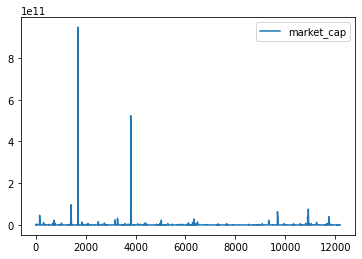

In [71]:
market_cap_filtered.plot.line(y='market_cap')

In [70]:
market_cap_filtered = pd.DataFrame(df[df['market_cap'] > 0]['market_cap']).sort_index(1, ascending=False)
market_cap_filtered.describe()


C:\Users\Gamer\AppData\Local\Temp/ipykernel_18128/2090280290.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_index will be keyword-only
  market_cap_filtered = pd.DataFrame(df[df['market_cap'] > 0]['market_cap']).sort_index(1, ascending=False)


,market_cap
count,1.840000e+03
mean,1.336831e+09
std,2.553628e+10
min,2.500000e+01
25%,5.543098e+05
50%,4.455455e+06
75%,5.558270e+07
max,9.475632e+11


<AxesSubplot:>

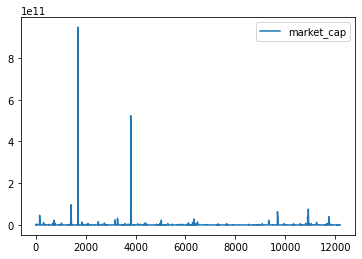

In [78]:
len(market_cap_filtered)
market_cap_filtered.plot(kind='line', y='market_cap')

In [84]:
print(df.dtypes)


currency_id             object
price                  float64
status                category
name                    object
market_cap             float64
circulating_supply     float64
volume                 float64
rank                     int32
high                   float64
high_timestamp          object
num_exchanges            int32
dtype: object


In [85]:
df.to_pickle('..\\downloaded_data\\nomics\\crypto_data.pkl')

In [86]:
test_df = pd.read_pickle('..\\downloaded_data\\nomics\\crypto_data.pkl')

In [87]:
test_df.head()

,currency_id,price,status,name,market_cap,circulating_supply,volume,rank,high,high_timestamp,num_exchanges
0,0XBTC,1.764247,active,0xBitcoin,14092189.0,7987650.0,0.0,700,4.094461,2018-06-06T00:00:00Z,15
1,0XCX,0.906010,active,0x (Currency.com),0.0,0.0,0.0,8050,1.326740,2021-11-11T00:00:00Z,1
2,0XGAS,3.606124,active,P2P Gas,0.0,0.0,0.0,6733,9.862572,2020-12-04T00:00:00Z,2
3,1000KISHU,0.000003,active,1000 KISHU,0.0,0.0,0.0,6790,0.000015,2021-05-15T00:00:00Z,1
4,1000SHIB2,0.037597,active,1000SHIB,0.0,0.0,0.0,2268,0.056697,2021-11-11T00:00:00Z,2


In [7]:
import pandas as pd
currency = 'BTC'
currency_data = pd.read_pickle(
        f"..\\downloaded_data\\nomics\\candles\\{currency}.pkl"
    )

In [9]:
type(currency_data)

pandas.core.frame.DataFrame